# Visualize GNNExplanations as molecular/tabular heatmaps

In [9]:
# imports
import os
import torch
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rdkit import Chem
from explanation_utils import visualize_features as vis



feature_labels = \
["Heavy neighb.",
"Hydrogen neighb.",
"Explicit valence",
"Aromaticity",
"In ring",
"Carbonyl C",
"\u03b1-C*", #α
"Methyl C",
"Amine N*",
"Carbonyl O",
"Methylene C*",
"Arg guanidinium C",
"Arg guanidinium \u03b5-NH", #ε
"Arg guanidinium NH\u2082",
"Asn/Gln N",
"Asp/Glu C",
"Cys S",
"sp\u00b2 CH",
"sp\u00b2 C",
"His imidazole N",
"His/Trp NH",
"Lys ammonium N",
"Met S",
"Pro \u03b1-C", #α
"Pro C",
"Pro backbone N",
"Hydroxyl O"]

color = (0x89, 0xd5, 0x48)
cmap = LinearSegmentedColormap.from_list("custom_cmap", [[1.]*3, [x/256 for x in color]], N=256)

# def data load functions
def load_feat_masks(folder):
    df = pd.read_csv(os.path.join(folder, "feat_masks.csv"), index_col=0)
    feat_masks = torch.tensor(df["feat_masks"].values).unsqueeze(1)
    feat_labels = list(df.index)
    return feat_masks, feat_labels

def load_node_masks(folder):
    df_node = pd.read_csv(os.path.join(folder, "node_masks.csv"), index_col=0)
    node_masks = torch.tensor(df_node["node_masks"].values)
    # node_labels = list(df_node["atoms"])
    # node_labels = [str(x)+" "+node_labels[x] for x in range(len(node_labels))]
    df_edge = pd.read_csv(os.path.join(folder, "node_edge_masks_aggr.csv"), index_col=0)
    edge_label = [eval(x) for x in df_edge.index]
    edge_masks = torch.tensor(df_edge["node_edge_masks_aggr"].values)
    aggr_edge_dict = {x:y for (x, y) in zip(edge_label, edge_masks)}
    df_info = pd.read_csv(os.path.join(folder, "info.csv"), index_col=0, header=None)
    smiles = df_info.loc["SMILES"].values[0]
    return node_masks, aggr_edge_dict, smiles #, node_labels

def load_indiv_masks(folder):
    df = pd.read_csv(os.path.join(folder, "indiv_masks.csv"), index_col=0)
    indiv_masks = torch.tensor(df.iloc[:,1:].values)
    return indiv_masks

def generate_atom_labels(mol2_file):
    mol = Chem.MolFromMol2File(mol2_file)
    atom_labels = [str(atom.GetIdx())+" "+atom.GetSymbol() for atom in mol.GetAtoms()]
    return atom_labels

def show_all(folder, mol2_file):
    node_masks, aggr_edge_dict, _ = load_node_masks(folder)
    feat_masks, _ = load_feat_masks(folder)
    indiv_masks = load_indiv_masks(folder)
    atom_labels = generate_atom_labels(mol2_file)

    # atoms and bonds
    im = vis.plot_highlight_mol_with_calc_colors(mol2_file, node_masks, aggr_edge_dict, color=color)
    display(im)
    # individual features
    vis.plot_indiv(indiv_masks, atom_labels, feature_labels, cmap=cmap, dpi=300)
    plt.show()
    plt.close()
    # features
    vis.plot_features(feat_masks, feature_labels, dpi=300, cmap=cmap)
    plt.show()
    plt.close()

def save_all(pdb_id, folder, mol2_file, save_folder):
    node_masks, aggr_edge_dict, _ = load_node_masks(folder)
    feat_masks, _ = load_feat_masks(folder)
    indiv_masks = load_indiv_masks(folder)
    atom_labels = generate_atom_labels(mol2_file)

    # atoms and bonds
    im = vis.plot_highlight_mol_with_calc_colors(mol2_file, node_masks, aggr_edge_dict, color=color)
    im.save(save_folder+pdb_id+"_"+"atom.png")
    # individual features
    vis.plot_indiv(indiv_masks, atom_labels, feature_labels, cmap=cmap, dpi=300)
    plt.savefig(save_folder+pdb_id+"_"+"indiv.png", bbox_inches="tight")
    plt.close()
    # features
    vis.plot_features(feat_masks, feature_labels, dpi=300, cmap=cmap)
    plt.savefig(save_folder+pdb_id+"_"+"feat.png", bbox_inches="tight")
    plt.close()

Run the cell below to generate visualizations within this notebook or use the `save_all` function instead to save the images to disk. The explanations for one example are already generated.

For the 3D-visualization the scripts in the `pymol_visualization` folder can be used.

*Important: To obtain the correct visualizations, the rdkit-drawing of the molecule has to be created from the original mol2 file of the ligand instead of the SMILES.* This is because the atom indexing is different between the two molecular representations and the explanations would be attributed to the wrong atoms. All test, valid and train ligands are supplied as mol2-files in `explainable_ligands`.

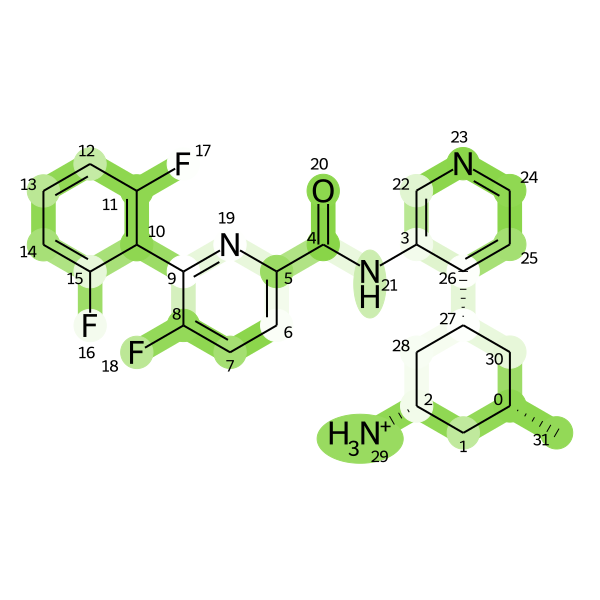

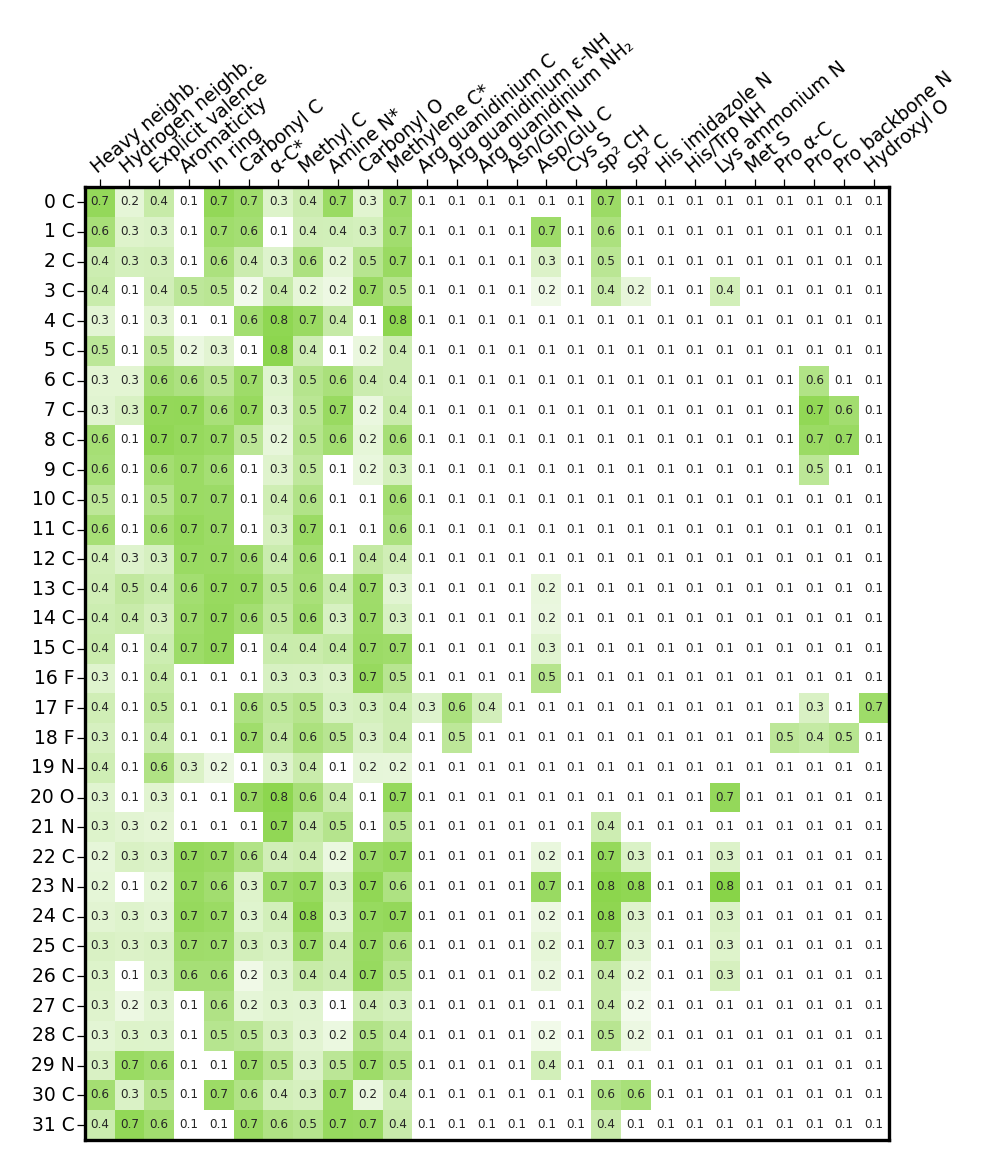

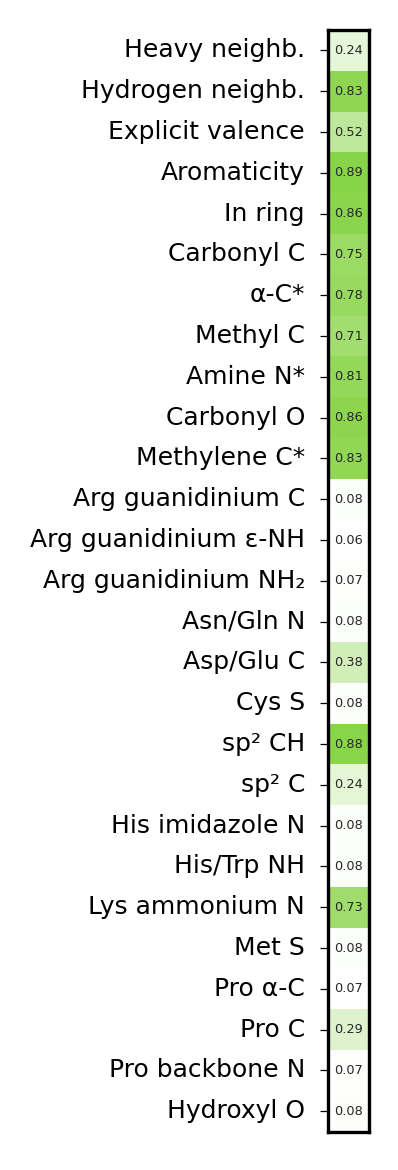

In [4]:
pdb_id="5dwr"
show_all(folder=f"explanation_outputs/{pdb_id}_100_explanations", 
    mol2_file=f"explainable_ligands/{pdb_id}_ligand.mol2")